# Validator Returns with Post-merge MEV

As Ethereum approaches the point at which its Proof of Stake (PoS) beacon chain — launched in December 2020 — will become the consensus engine for mainnet, much online coverage has focused on the end of Proof of Work mining and concomitant reductions in both energy usage and issuance of Ether (never mind that PoS is [more secure and resistant to centralisation](https://vitalik.ca/general/2020/11/06/pos2020.html)). However another consequence of the beacon chain taking over transaction inclusion and ordering duties is that the fees currently paid to miners for transaction inclusion will instead be paid to the block *proposer*. That is, a validator, selected at random to propose a block every 12 seconds.

The manner in which validators are selected to propose blocks does not change from the existing process, and as I showed in my [first article on validator returns](https://pintail.xyz/posts/beacon-chain-validator-rewards/#block-rewards), this produces some random variation in revenue, even when validators participate perfectly. So for this article, the question is how much validator returns are affected by the fees they receive for including transactions on Ethereum's execution layer.

## But What's MEV?

In the title, I've referred to these execution layer fees as 'MEV'. Perhaps this is a little confusing — [the term MEV](https://docs.flashbots.net/Flashbots-auction/miners/faq/#what-is-mev) can stand for "miner extractable value" or "maximal extractable value" — neither of which seems to describe the fees received by validators for including/ordering transactions in post-merge Ethereum blocks. Validators are not miners, and in what sense might this value be 'maximal', anyway? The reality is that the term MEV has entered common usage to describe whatever value is — or could be — paid to the the entity responsible for transaction inclusion and ordering. To reduce the ambiguity, the Flashbots team have introduced the term "Realised Extractable Value" to describe the value actually obtained, rather than a theoretical maximum. However, even this leaves some ambiguity — are we talking about the value that is 'realised' by searchers, or the amount that is actually paid to searchers? For simplicity therefore, since 'MEV' is the term with widespread adoption, it is what I will use here to refer to revenue which is received by miners/validators (I know [all too well](https://pintail.medium.com/uniswap-a-good-deal-for-liquidity-providers-104c0b6816f2) how difficult it can be to change a term once it has entered widespread use).

So why use a fancy term (MEV) when we could use a straightforward one (transaction fees)? There are several reasons. Revenue from transaction inclusion and ordering has been revolutionised since Flashbots introduced a fork of the dominant Ethereum execution client, geth. As of August 2022, [approximately 74%](https://dashboard.flashbots.net/) of Ethereum's hashrate is running mev-geth, since doing so allows miners to receive bundles of transactions which exploit time-sensitive profit opportunities and are rewarded with direct payment (previously much of this revenue was wasted in a wasteful *priority gas auction* process). The use of the term MEV recognises this new complexity. Furthermore, the opportunity for validators to benefit from the same revenue stream post-merge is being offered by Flashbots through [mev-boost](https://boost.flashbots.net/). However, whether or not validators choose to run mev-boost, the fees they receive for block proposal can still be described in a broad sense as MEV. More importantly, perhaps, since the London hard fork introduced EIP-1559, the portion of transaction fees which was in effect acting as a [congestion charge](https://barnabe.substack.com/p/congestion-control-and-eip1559) is no Longer paid to miners at all — it is instead burned. This means that the vast majority of miner fee revenue is now made up from those transactions which pay a special premium to miners due to the value they capture, i.e. MEV, since non-time-sensitive transactions only pay a nominal charge to the miner for inclusion.

## Previous Model

An article setting out [an early exploration](https://hackmd.io/@flashbots/mev-in-eth2#) (with [accompanying notebook](https://github.com/flashbots/eth2-research/blob/main/notebooks/mev-in-eth2/eth2-mev-calc.ipynb)) of the implications of this change  was published by Alex Obadia and Taarush Vemulapalli from Flashbots in July 2021, by looking specifically at Flashbots transaction bundles from a sample of approx 100,000 blocks. Firstly they averaged across blocks, applying a fixed amount of MEV per block. Then they looked at the 1st and 99th centiles within that dataset to establish some bounds for the impact on validator returns (finding a very wide variation as a result of this approach).

In this article I'll develop this approach a bit further by:
1. Looking at fee revenue in its entirety (rather than only Flashbots bundles), since all miner fee revenue can be considered a form of MEV.
1. Using a larger dataset and considering how the levels of MEV have varied over time.
1. Modelling the whole distribution of outcomes.
1. Calculating how these distributions change for users running multiple validators.

One point observed in the above article was that it was difficult to reason about the impact of EIP-1559 on the fees paid to miners (the London hard fork which introduced EIP-1559 was not live at the time the article was written). Now however we have plenty of data on this — the stacked chart below shows the portion of the fees (in green) which were previously being paid to miners, but since the London hard fork are instead subtracted from the Ether supply (burned). Clearly data from before and after the London hard fork are not comparable. For that reason, in this article we will deal only with data from the period *after* the London hard fork.

In [1]:
# imports / constants / db connection

In [2]:
import math
from random import randrange, random, sample
from datetime import datetime, timedelta
from time import time

import psycopg2
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

from web3 import Web3

class Ecdf(pd.Series):
    def __init__(self, data):
        s = pd.Series(data)
        super().__init__(s.value_counts().sort_index().cumsum()*1./len(s))
        
    def get_quantile(self, q):
        #self[self.ge(random())].index[0]
        return self.index[np.argmax(self.array >= q)] # faster
        
    def get_scaled_ecdf(self, scaling_factor):
        index = [v * scaling_factor for v in self.index.values]
        scaled_ecdf = self.set_axis(index)
        scaled_ecdf.__class__ = Ecdf
        return scaled_ecdf

start_block = 13136427 # first block of September 2021
end_block = 15449617 # last block of August 2022

SECONDS_PER_SLOT = 12

# close existing connection to mev-inspect database

try:
    cursor.close()
    connection.close()
except:
    pass

# connect to mev-inpect database

connection = psycopg2.connect(
    host="127.0.0.1",
    port=5433,
    user="postgres",
    password="password",
    database="mev_inspect"
)
connection.autocommit = True
cursor = connection.cursor()

In [3]:
# get block summary data from db as pandas dataframe

In [3]:
sql = (
    "SELECT * FROM block_totals WHERE block_number BETWEEN %s AND %s "
    "ORDER BY block_number"
)
cursor.execute(sql, (start_block, end_block))

(
    block_numbers, block_timestamps, base_fees, gas_used,
    net_transfers, net_fees, burned_fees, ts_diff_1, ts_diff_2
) = zip(*cursor.fetchall())

miner_extracted = [float(t + f) for t, f in zip(net_transfers, net_fees)]

# save data into a pandas dataframe 

df = pd.DataFrame({
    'block_number': [int(bn) for bn in block_numbers],
    'timestamp': pd.to_datetime(block_timestamps),
    'gas_used': [int(gu) for gu in gas_used],
    'base_fee': [int(bf) for bf in base_fees],
    'net_transfers': [float(nt) for nt in net_transfers],
    'net_fees': [float(nf) for nf in net_fees],
    'miner_extracted': miner_extracted,
    'burned_fees': [float(bf) for bf in burned_fees],
    'ts_diff_1': [int(ts) for ts in ts_diff_1],
    'ts_diff_2': [int(ts) for ts in ts_diff_2]
})

In [4]:
# plot daily fees/coinbase transfers

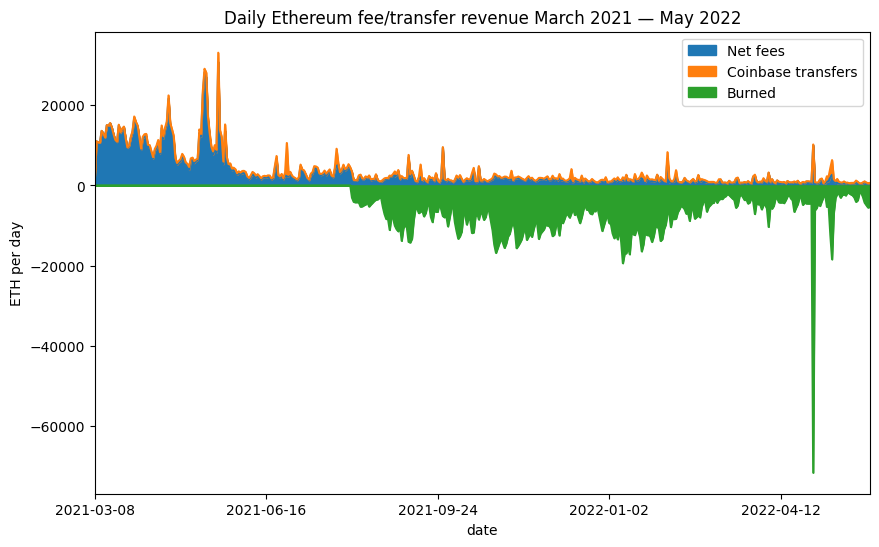

In [5]:
daily = pd.read_csv('daily_totals.csv')
daily['net_fees'] = daily['total_fee_revenue'] - daily['total_basefee_cost']
daily['burned_ether'] = -1 * daily['total_basefee_cost']

fig, ax = plt.subplots(figsize=(10, 6))

daily.set_index('date', inplace=True)
daily.rename(inplace=True, columns={
    'net_fees': 'Net fees',
    'total_transfer_revenue': 'Coinbase transfers',
    'burned_ether': 'Burned'
})
daily[['Net fees', 'Coinbase transfers', 'Burned']].plot.area(
    ax=ax, ylabel="ETH per day"
)
ax.margins(x=0)
ax.set_title('Daily Ethereum fee/transfer revenue March 2021 — May 2022');

## Selecting a Dataset

For this article, we're going to work with historical data to try and use this to get a sense of roughly what to expect in the future (while remembering that in things financial, such an approach is not reliable). As explained in my [last article](https://pintail.xyz/posts/gas-market-analysis/), the transaction fee market changed significantly in August 2021 due to the implementation of EIP-1559 as part of the London hard fork which went live at block 12,965,000 and therefore data from before this point is not comparable with more recent data. The hard fork following this was [Gray Glacier](https://blog.ethereum.org/2022/06/16/gray-glacier-announcement), which went live at block 15,050,000 and pushed back Ethereum's difficulty bomb. However, average block intervals had begun to change a while before this. As we'll see later on, changes in block interval seem to have limited impact on the MEV available, so we will not worry about the slightly increased average block interval leading up to Gray Glacier.

So we have just over a year of data available since the London hard fork. In fact we might as well take exactly a year a of data, since that allows for a period after London for the fee market to settle. So we'll be looking at the range from block 13,136,427 (the first block mined on 1 September 2021) until block 15,449,617 (the last block mined on 31 August 2022). This gives us 1 full year of data, comprising approximately 2.3m blocks.

Having chosen this block range, we need to identify how much revenue is going to the miner of each block. For this we'll be using Flashbots' [mev-inspect-py](https://github.com/flashbots/mev-inspect-py) tool which (amongst many other features) scrapes blocks for "coinbase transfer" transactions as well as aggregating fees. This is because there are two main ways in which miners are paid for including Flashbots bundles of MEV-carrying transactions — either by setting a sufficiently high transaction fee, or including a direct payment to the miner as part of the transaction. [For reasons of gas-efficiency](https://youtu.be/dBvAcDkIe2Y) there has been a tendency towards searchers using gas fees rather than coinbase transfers to pay miners. Still, we'd like to include both in our dataset for a more complete picture.

We have to do a little bit more work to determine the amount of MEV per block. First we have to exclude transactions that miner pay to themselves since these are not economically meaningful. This requires identifying multiple addresses controlled by a single mining pool (this involved some manual sleuthing on Etherscan) and then labelling each transaction according to whether its sender address was in a mining pool group, and labelling each block according the mining pool which produced it ([see script 1](https://github.com/pintail-xyz/post-merge-mev/blob/master/add_miner_labels.py)). Once this was done, it was possible to produce a per-block MEV summary which subtracted the Ether burned by EIP-1559 and excluded intra-pool transfers, with the results saved as an extra table in the Postgres database populated by mev-inspect-py ([see script 2](https://github.com/pintail-xyz/post-merge-mev/blob/master/block_totals.py)).

Finally, [one transaction](https://etherscan.io/tx/0x2c9931793876db33b1a9aad123ad4921dfb9cd5e59dbb78ce78f277759587115) stood out as having a much larger transaction fee than any other (7676 ETH). In fact this transaction fee on its own was worth about USD 23m, and accounted for a significant proportion of all the MEV extracted over the period. It turned out in this case the high fee was [the result of a bug](https://rhino.fi/blog/23-7-million-dollar-ethereum-transaction-fee-post-mortem/) and in fact the vast majority of the fee was returned by the miner. With this in mind I chose to exclude this transaction from the dataset.

## Digression: Block Intervals

Before we start digging into the data to develop our model for post-Merge MEV, we should think about the ways in which block proposal under PoS differs from the current mechanism. One important difference for us to be concerned about is the block interval.

After the merge, rather than having variable block intervals with an average of about 13.5s, we will have a fixed block interval of 12s. The obvious consequence of this is that post-merge Ethereum will have slightly higher throughput by virtue of having slightly more frequent blocks. However, the subtler consequence is that the variability of block intervals will decrease dramatically. In pre-merge (i.e. proof of work) Ethereum, the amount of time between blocks successive blocks approximates an exponential distribution. This is because Ethereum block production is well-modelled as a *Poisson process* — that is, the probability of finding the next block within time $\delta$ remains constant. Take a look at the histogram of block intervals below, which is based on the timestamps which miners attach to their blocks.

In [6]:
# plot block interval histogram

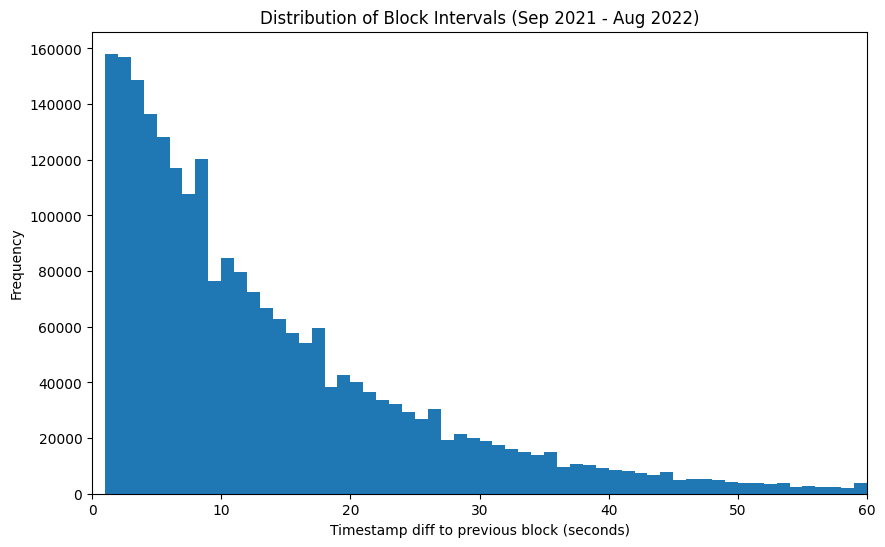

In [7]:
fig, ax = plt.subplots(figsize=(10, 6))
df['ts_diff_1'].plot.hist(bins=[b for b in range(61)], ax=ax)
ax.set_xlabel('Timestamp diff to previous block (seconds)')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Block Intervals (Sep 2021 - Aug 2022)')
ax.set_xlim(xmin=0, xmax=60);

This chart shows that in broad outline the block interval on pre-merge Ethereum does follow the the shape of an exponential distribution. It's not perfect — timestamp resolution is only down to 1s, and no two blocks in the canonical chain can have the same timestamp (hence no bar at 0s).

The slightly more confusing effect is the surplus of blocks that show up in every 9th second of the distribution. I'm not the only person to have spotted this effect, which is the result of miners' ability to set the timestamp on blocks they produce. It turns out that some miners appear to have abused this power to slightly reduce their risk of mining an uncle block and hence increase their profitability:

<blockquote class="twitter-tweet"><p lang="en" dir="ltr">Do miners execute consensus-level attack against Ethereum (or other major tokens)❓🤔<br>The answer is *yes*❗🤯<br>Read on for full deets 👇<br>Joint work with Gilad Stern and <a href="https://twitter.com/Avivz78?ref_src=twsrc%5Etfw">@Avivz78</a>.<br>Full paper: <a href="https://t.co/PffJRQ3X3W">https://t.co/PffJRQ3X3W</a><br>Medium post: <a href="https://t.co/qMOsRrN5DJ">https://t.co/qMOsRrN5DJ</a><br>... (1/12)</p>&mdash; Aviv Yaish (@yaish_aviv) <a href="https://twitter.com/yaish_aviv/status/1555445499041300481?ref_src=twsrc%5Etfw">August 5, 2022</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script> 

Regardless of whether miners sometimes manipulate block timestamps, as is clear from the distribution above, blocks are very frequently mined in quick succession. There are also sometimes very long intervals between successive blocks — a minute or more. Intuitively, we might think that a longer block interval means more time to collect more fees, and therefore greater miner revenue. To investigate this I looked at the median miner revenue, plotted below, where the median is taken from blocks grouped by the timestamp difference from block $n$ to block $n-1$ (blue line), and then by the time difference between blocks $n-1$ and $n-2$ (orange line).

In [8]:
# plot median fees by block interval

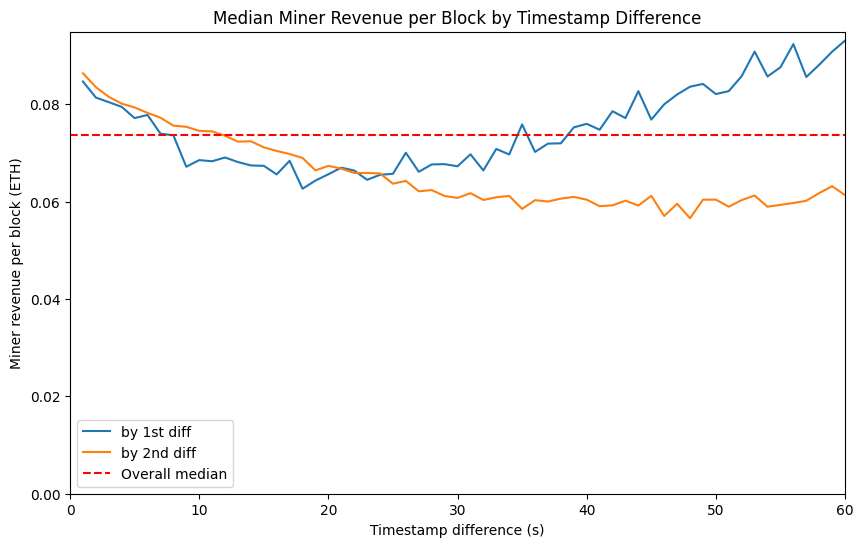

In [9]:
diff1_med = df.groupby('ts_diff_1')['miner_extracted'].median()
diff2_med = df.groupby('ts_diff_2')['miner_extracted'].median()
fig, ax = plt.subplots(figsize=(10, 6))
diff1_med[:61].plot(ax=ax, label='by 1st diff')
diff2_med[:61].plot(ax=ax, label='by 2nd diff')
median_mev = df['miner_extracted'].median()
ax.axhline(median_mev, color='r', linestyle='dashed', label='Overall median')
ax.set_ylim(ymin=0)
ax.set_xlim(xmin=0, xmax=60)
ax.set_title('Median Miner Revenue per Block by Timestamp Difference')
ax.set_xlabel('Timestamp difference (s)')
ax.set_ylabel('Miner revenue per block (ETH)')
ax.legend();

What we observe is confusing. Based on the first timestamp difference, rewards seem to drop off initially and then build up for longer block intervals. When we look at the second timestamp difference, MEV rates seem only to reduce further and further, the longer the block interval. I have theories about why these patterns might be. But I will move on rather than present them here because (a) I'm not confident about them and (b) this problem is no longer relevant post-merge, once block times are fixed.

What I will conclude from this digression is that the block interval does not seem to have a dramatic impact on miner revenue — the median by block interval remains within about 20% of the overall median. Therefore for the remainder of this article, I will treat post-merge miner revenue as being broadly equivalent to pre-merge miner revenue, and will not make allowances for the change from a variable to fixed block interval. We might reasonably expect that variability of miner revenue will decrease somewhat as a result of the reduced variability in block interval, but the effect will not be large.

I will make some attempt to try and account for the slightly increased average frequency of blocks, going from a mean interval of 13.5s to 12s, by inversely scaling all miner revenue amounts by this ratio. Of course, real markets are more complicated than this, but lacking a more rigorous way of accounting for this difference, proportional scaling will have to do.

## Historical MEV levels

Let's take a look at how much MEV a miner could expect to receive in a typical block. The two plots below illustrate this. The histogram (upper) shows that per-block miner revenue is most often very low — with frequencies for higher amounts of miner revenue dropping off rapidly. The second plot may be slightly less intuitive but actually tells us much more. We can see that the median miner revenue is 0.07 ETH (i.e. 50% of blocks paid their miners this amount or less, 50% paid more). A few other points have been marked on the plot, so we can see the lowest-value 1% of blocks paid nothing at all to the miner, whereas the highest-value 1% of blocks paid over 1.8 ETH to the miner. As shown in the table below (but not on the chart, since it would distort the axes too much), the top 0.1% of blocks paid 12.5 ETH or more to the miner.

In [10]:
# plot block revenue histogram and empirical cumulative density function (ecdf)

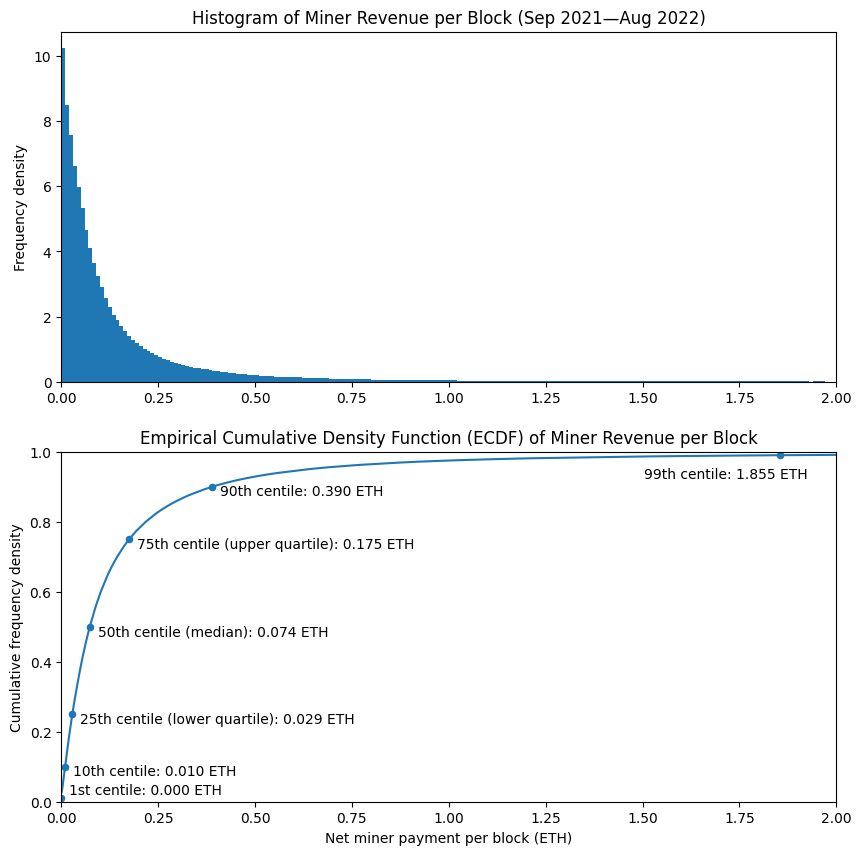

centile(%),revenue(ETH per block)
1.0,0.000
10.0,0.010
25.0,0.029
50.0,0.074
75.0,0.175
90.0,0.390
99.0,1.855
99.9,12.462


In [60]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 10))

bins = [e/100 for e in range(201)]
df['miner_extracted'].hist(ax=ax1, bins=bins, density=True, grid=False)
ax1.set_title('Histogram of Miner Revenue per Block (Sep 2021—Aug 2022)')
ax1.set_xlim(0, 2)
ax1.set_ylabel('Frequency density')

mev_ecdf = Ecdf(df['miner_extracted'])
mev_ecdf.plot(ax=ax2, label='ECDF')

quantiles = [.01, .1, .25, .5, .75, .9, .99, .999]

table = pd.DataFrame({
    'quantile': quantiles,
    'centile': [100 * q for q in quantiles],
    'revenue<br>(ETH per block)': [mev_ecdf.get_quantile(q) for q in quantiles]
})
table.set_index('quantile', inplace=True, drop=False)
table.plot('revenue<br>(ETH per block)', 'quantile', kind='scatter', ax=ax2)

ax2.set_title(
    'Empirical Cumulative Density Function (ECDF) of Miner Revenue per Block'
)
ax2.set_xlim(0,2)
ax2.set_xlabel('Net miner payment per block (ETH)')
ax2.set_ylim(0,1)
ax2.set_ylabel('Cumulative frequency density')

c1 = table['revenue<br>(ETH per block)'].loc[0.01]
ax2.annotate(f'1st centile: {c1:.3f} ETH', (c1 + 0.02, 0.02))
d1 = table['revenue<br>(ETH per block)'].loc[0.1]
ax2.annotate(f'10th centile: {d1:.3f} ETH', (d1 + 0.02, 0.075))
lq = table['revenue<br>(ETH per block)'].loc[0.25]
ax2.annotate(f'25th centile (lower quartile): {lq:.3f} ETH', (lq + 0.02, 0.225))
med = table['revenue<br>(ETH per block)'].loc[0.5]
ax2.annotate(f'50th centile (median): {med:.3f} ETH', (med + 0.02, 0.475))
uq = table['revenue<br>(ETH per block)'].loc[0.75]
ax2.annotate(f'75th centile (upper quartile): {uq:.3f} ETH', (uq + 0.02, 0.725))
d9 = table['revenue<br>(ETH per block)'].loc[0.9]
ax2.annotate(f'90th centile: {d9:.3f} ETH', (d9 + 0.02, 0.875))
c99 = table['revenue<br>(ETH per block)'].loc[0.99]
ax2.annotate(f'99th centile: {c99:.3f} ETH', (c99 - 0.35, 0.925))

plt.show()

table.rename(columns={'centile': 'centile<br>(%)'}, inplace=True)

table[
    ['centile<br>(%)', 'revenue<br>(ETH per block)']
].style.set_table_styles(
    [dict(selector='th', props=[('text-align', 'center')])]
).hide().format(
    {'centile<br>(%)': '{:.1f}', 'revenue<br>(ETH per block)': '{:.3f}'}
)

## MEV Trends
The histogram and ECDF above are based on taking our whole year of data and treating it as though it were one static distribution. However, we might think that levels of miner revenue would vary over time, and that the distribution of miner revenue would depend on various factors like the level of on-chain activity, or by trends around the proportion of available MEV which is paid to miners, or the amount of MEV available on the base chain as compared with L2 blockchains.

To investigate this, the chart below shows the median block reward for each week of the dataset, with the overall median we saw previously indicated by the dashed red line. The reason to do this on a weekly basis is that on-chain activity tends to follow a weekly cycle, with lower activity at the weekends. From this chart, clearly the weekly median level of miner revenue was both higher and more volatile in the earlier portion of the dataset than later on. If we divide the dataset in two (with the orange line marking the 6-month point), it seems as though we could think of the two halves of the dataset as separate, representing the levels of MEV paid to the miner under different network/market conditions. One thing that this variability should tell us however is that we cannot have a great deal of confidence in any estimates we make concerning future revenue which are based on historical data (keep this in mind, since it is exactly what I will be doing in the latter portion of this article).

Finally, as expected based on our earlier exploration of the impact of block timings, there is no clear impact observed around the time of the Gray Glacier hard fork (green dashed line), so we will keep this data in the dataset.

In [12]:
# Look at variation across the dataset

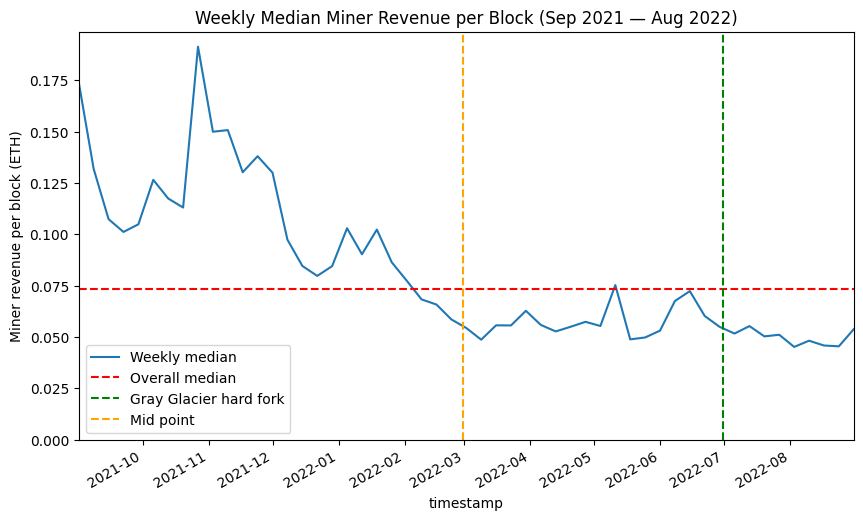

In [13]:
nanoseconds_per_week = 10**9 * 60 * 60 * 24 * 7
df['week'] = (
    df['timestamp'].astype(int) - df['timestamp'].astype(int).iloc[0]
) // nanoseconds_per_week
weekly_data = {
    'timestamp': df.groupby(['week'])['timestamp'].first(),
    'median': df.groupby(['week'])['miner_extracted'].quantile(0.5)
}
weekly = pd.DataFrame(weekly_data)

fig, ax = plt.subplots(figsize=(10, 6))
weekly.set_index('timestamp', inplace=True)
weekly['median'].plot(ax=ax, label='Weekly median')
ax.axhline(median_mev, color='r', linestyle='dashed', label='Overall median')
gg = datetime(2022, 6, 30, 10, 54, 4)
ax.axvline(gg, color='g', linestyle='dashed', label='Gray Glacier hard fork')
midpoint = df['timestamp'].iloc[len(df) // 2]
ax.axvline(midpoint, color='orange', linestyle='dashed', label='Mid point')
ax.set_title('Weekly Median Miner Revenue per Block (Sep 2021 — Aug 2022)')
ax.set_ylabel('Miner revenue per block (ETH)')
ax.set_ylim(ymin=0)
ax.set_xlim(weekly.index.min(), weekly.index.max())
ax.legend();

Since the levels of miner revenue across our year-long dataset are evidently not static, let's try comparing the first half of the dataset with the second half in a more detailed way. In the plot below you can see the ECDFs for the two halves of the dataset. With the blue line (representing the first half of the dataset) below the orange line (representing the second half) and since we have revenue along the x-axis, this means that at every quantile, the levels of miner revenue were higher in the first half of the dataset. The ECDF for the whole dataset which was shown in the previous plot would fall in between these two lines. As shown in the table below, the median (50th centile) per-block MEV amount was just over half as much in the second 6-month block as it was in the first.

In [14]:
# Generate ECDFs for the first half of the dataset versus the second

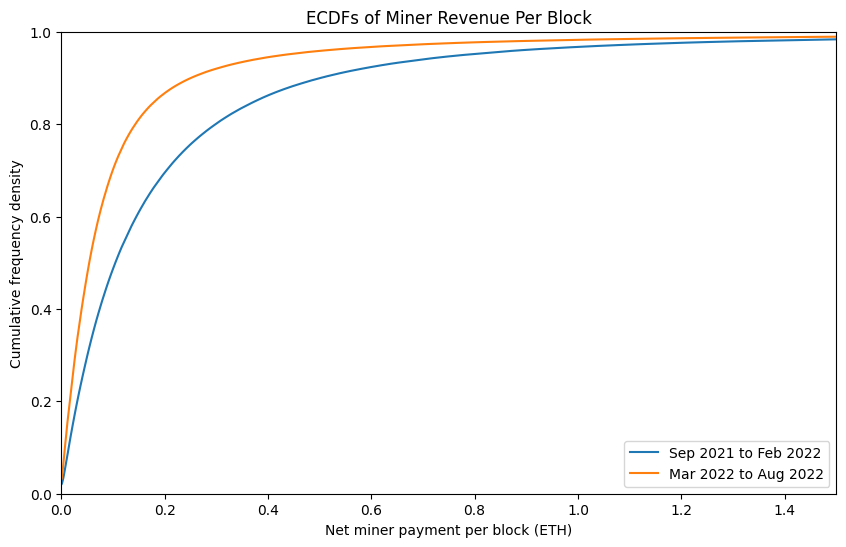

In [15]:
mev_ecdf_h1 = Ecdf(df['miner_extracted'].iloc[:len(df) // 2])
mev_ecdf_h2 = Ecdf(df['miner_extracted'].iloc[len(df) // 2:])

fig, ax = plt.subplots(figsize=(10, 6))
mev_ecdf_h1.plot(ax=ax, label='Sep 2021 to Feb 2022')
mev_ecdf_h2.plot(ax=ax, label='Mar 2022 to Aug 2022')

ax.set_title('ECDFs of Miner Revenue Per Block')
ax.set_xlim(0,1.5)
ax.set_xlabel('Net miner payment per block (ETH)')
ax.set_ylim(0,1)
ax.set_ylabel('Cumulative frequency density')
ax.legend()
plt.show()

quantiles = [0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99, 0.999]

table = pd.DataFrame({
    'centile': [100 * q for q in quantiles],
    'h1': [mev_ecdf_h1.get_quantile(q) for q in quantiles],
    'h2': [mev_ecdf_h2.get_quantile(q) for q in quantiles]
})
cols = [
    ('', 'centile (%)'),
    ('Revenue per block (ETH)', 'Sep 2021<br>to Feb 2022'),
    ('Revenue per block (ETH)', 'Mar 2022<br>to Aug 2022')
]
fmts = ['{:.1f}', '{:.3f}','{:.3f}']
col_formats = {c: f for c, f in zip(cols, fmts)}
table.columns = pd.MultiIndex.from_tuples(cols)
display(
    table.style.set_table_styles(
        [dict(selector='th', props=[('text-align', 'center')])]
    ).hide(axis='index').format(col_formats)
)

## Simulating Post-Merge Returns from MEV

So, bringing together what we have learned about historical block revenues for miners, let's have a go at modelling what validator returns from MEV might look like over the course of a year. Since we're now thinking about validators instead of miners, I'll express the results as percentage return on 32 ETH. We haven't arrived at an analytical expression for the distribution of per-block revenues (in my time spent trying to come up with a sensible expression based on a Pareto distribution, a suitable formulation proved elusive). This slightly complicates modelling and means in this case we're going to resort to a Monte Carlo simulation.

The basic methodology is simple — generate a random number uniformly distributed between 0 and 1, and use this number to perform a lookup from the ECDF we calculated earlier (with the ECDF scaled to account for the 13.5s to 12s change in average block intervals). Assign the block's revenue to a randomly selected validator. Repeat until we have a year's worth of simulated blocks (2,629,746 blocks in total). We'll do this 3 times — using the ECDF derived from the whole year-long dataset, and then also using ECDFs from the first and second halves of the dataset.

We're going to assume perfect validator performance (no missed block proposals). We're also going to use a validator set size of 420,000, close to the current size of the validator set in August 2022. This number of validators also divides exactly into groups of 32, which will be useful when we look at groups of validators later on.

In [16]:
# simulate a year's worth of block proposals

In [18]:
# calculate average block interval
mean_interval = (df['timestamp'].max() - df['timestamp'].min()) / (len(df) - 1)
scaling_factor = SECONDS_PER_SLOT / mean_interval.total_seconds()
scaled_mev_ecdf = mev_ecdf.get_scaled_ecdf(scaling_factor)
scaled_mev_ecdf_h1 = mev_ecdf_h1.get_scaled_ecdf(scaling_factor)
scaled_mev_ecdf_h2 = mev_ecdf_h2.get_scaled_ecdf(scaling_factor)

num_validators = 420000
validators = [0] * num_validators
validators_h1 = [0] * num_validators
validators_h2 = [0] * num_validators
seconds_per_year = 31556952
slots_per_year = seconds_per_year // SECONDS_PER_SLOT

start_time = time()
last_update = 0

for slot in range(slots_per_year):
    # random selection of validator as proposer
    ind = randrange(num_validators)
    rn = random()
    # random sampling of MEV level for the block
    validators[ind] += scaled_mev_ecdf.get_quantile(rn)
    validators_h1[ind] += scaled_mev_ecdf_h1.get_quantile(rn)
    validators_h2[ind] += scaled_mev_ecdf_h2.get_quantile(rn)
    
    t = time()
    if t - last_update > 0.1:
        percentage = 100 * (slot+1) / slots_per_year
        elapsed = timedelta(seconds=int(t - start_time))
        print(f"{percentage:.2f}% / {elapsed} elapsed", end='\r')
        last_update = t

rtn = pd.Series([100 * v / 32 for v in validators])
annual_mev_ecdf = Ecdf(rtn)
annual_mev_ecdf_h1 = Ecdf([100 * v / 32 for v in validators_h1])
annual_mev_ecdf_h2 = Ecdf([100 * v / 32 for v in validators_h2])

In [19]:
# plot ECDF and histogram for single validator return

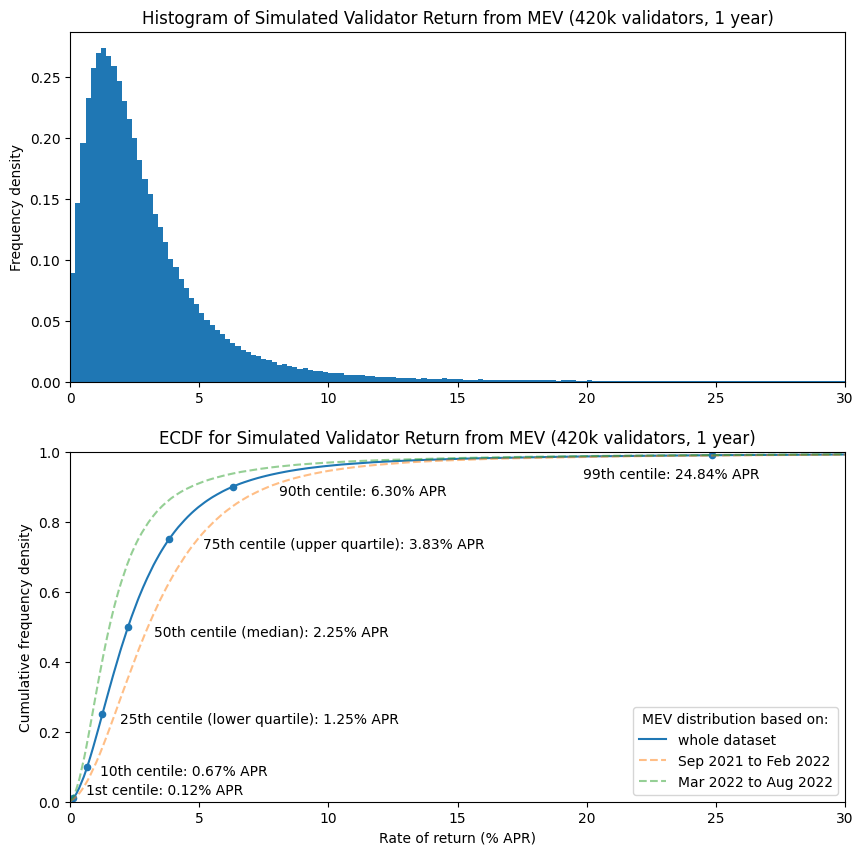

In [61]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 10))

bins = [e/5 for e in range(151)]
rtn.hist(ax=ax1, bins=bins, density=True, grid=False)
ax1.set_title(
    'Histogram of Simulated Validator Return from MEV (420k validators, 1 year)'
)
ax1.set_xlim(0, 30)
ax1.set_ylabel('Frequency density')

annual_mev_ecdf.plot(ax=ax2, label="whole dataset")
annual_mev_ecdf_h1.plot(
    ax=ax2, linestyle='dashed', alpha=0.5, label="Sep 2021 to Feb 2022"
)
annual_mev_ecdf_h2.plot(
    ax=ax2, linestyle='dashed', alpha=0.5, label="Mar 2022 to Aug 2022"
)

quantiles = [.01, .1, .25, .5, .75, .9, .99, .999]

table = pd.DataFrame({
    'quantile': quantiles,
    'centile': [100 * q for q in quantiles],
    'all': [annual_mev_ecdf.get_quantile(q) for q in quantiles],
    'h1': [annual_mev_ecdf_h1.get_quantile(q) for q in quantiles],
    'h2': [annual_mev_ecdf_h2.get_quantile(q) for q in quantiles]
})
table.set_index('quantile', inplace=True, drop=False)
table.plot('all', 'quantile', kind='scatter', ax=ax2)

c1 = table['all'].loc[0.01]
ax2.annotate(f'1st centile: {c1:.2f}% APR', (c1 + 0.5, 0.02))
d1 = table['all'].loc[0.1]
ax2.annotate(f'10th centile: {d1:.2f}% APR', (d1 + 0.5, 0.075))
lq = table['all'].loc[0.25]
ax2.annotate(f'25th centile (lower quartile): {lq:.2f}% APR', (lq + 0.7, 0.225))
med = table['all'].loc[0.5]
ax2.annotate(f'50th centile (median): {med:.2f}% APR', (med + 1, 0.475))
uq = table['all'].loc[0.75]
ax2.annotate(f'75th centile (upper quartile): {uq:.2f}% APR', (uq + 1.3, 0.725))
d9 = table['all'].loc[0.9]
ax2.annotate(f'90th centile: {d9:.2f}% APR', (d9 + 1.8, 0.875))
c99 = table['all'].loc[0.99]
ax2.annotate(f'99th centile: {c99:.2f}% APR', (c99 - 5, 0.925))

ax2.set_title(
    'ECDF for Simulated Validator Return from MEV (420k validators, 1 year)'
)
ax2.set_xlabel('Rate of return (% APR)')
ax2.set_xlim(0, 30)
ax2.set_ylabel('Cumulative frequency density')
ax2.set_ylim(0, 1)
ax2.legend(title='MEV distribution based on:', loc='lower right')

plt.show()

table.drop('quantile', axis=1, inplace=True)
cols = [
    ('','centile <br>(%)'),
    ('Rate of return (% APR)<br>based on data from:','Sep 2021<br>to Aug 2022'),
    ('Rate of return (% APR)<br>based on data from:','Sep 2021<br>to Feb 2022'),
    ('Rate of return (% APR)<br>based on data from:','Mar 2022<br>to Aug 2022'),
]

fmts = ['{:.1f}'] + ['{:.2f}'] * 3
col_formats = {c: f for c, f in zip(cols, fmts)}
table.columns = pd.MultiIndex.from_tuples(cols)
display(
    table.style.set_table_styles(
        [dict(selector='th', props=[('text-align', 'center')])]
    ).hide(axis='index').format(col_formats)
)

## Modelling Full Validator Returns

Now we can see approximate validator returns from MEV, let's compete the simulation by including rewards for attestation and sync committees too. Since [beaconcha.in](beaconcha.in) regularly indicates participation rates over 99% on the beacon chain, we'll keep our simulation simple by assuming perfect participation. In practice, if the conditions we see on mainnet today persist after the merge, the vast majority of variability in validator rewards will come from the random assignment of proposer duties, sync committees and MEV, rather than being due to validator performance.

Therefore in the simulation below, all validators given an identical reward for perfect attestation performance, but a committee of 512 validators is selected at random every 256 epochs, and that committee then earns a full sync committee reward, for perfect participation over the subsequent 256 epochs. MEV per block is selected in the same way as before, but now validators receive beacon chain proposer rewards, as well as execution layer transaction fees (MEV).

In [34]:
# model full validator returns using previously calculated MEV ECDFs

In [38]:
num_validators = 420000

HEAD_WT = 14
SOURCE_WT = 14
TARGET_WT = 26
SYNC_WT = 2
PROPOSER_WT = 8
BASE_REWARD_FACTOR = 64
WEIGHT_DENOM = 64
EPOCHS_PER_COMMITTEE = 256
COMMITTEE_SIZE = 512
SLOTS_PER_EPOCH = 32
GWEI_PER_ETH = int(1e9)
gwei_per_validator = int(32e9)
staked_gwei = gwei_per_validator * num_validators
epochs_per_year = slots_per_year // SLOTS_PER_EPOCH

base_reward = gwei_per_validator * BASE_REWARD_FACTOR // math.isqrt(staked_gwei)
total_reward = base_reward * num_validators

att_reward = base_reward * (HEAD_WT + SOURCE_WT + TARGET_WT) // WEIGHT_DENOM
annual_attestation_reward_eth = att_reward * epochs_per_year / GWEI_PER_ETH

# perfect performance so all validators get full attestation reward for the year
validators = [annual_attestation_reward_eth] * num_validators
validators_h1 = [annual_attestation_reward_eth] * num_validators
validators_h2 = [annual_attestation_reward_eth] * num_validators

prop_reward = total_reward * PROPOSER_WT // WEIGHT_DENOM // SLOTS_PER_EPOCH
prop_reward_eth = prop_reward / GWEI_PER_ETH
sync_reward = total_reward * SYNC_WT // WEIGHT_DENOM // SLOTS_PER_EPOCH \
              // COMMITTEE_SIZE
sync_reward_eth = sync_reward / GWEI_PER_ETH

start_time = time()
last_update = 0

for slot in range(slots_per_year):
    # process sync committee:
    if slot % (32 * EPOCHS_PER_COMMITTEE) == 0:
        # select sync committee
        committee = sample(range(num_validators), COMMITTEE_SIZE)
    for ind in committee:
        validators[ind] += sync_reward_eth
        validators_h1[ind] += sync_reward_eth
        validators_h2[ind] += sync_reward_eth
            
    # random selection of validator as proposer
    ind = randrange(num_validators)
    r = random()
    validators[ind] += scaled_mev_ecdf.get_quantile(r) + prop_reward_eth
    validators_h1[ind] += scaled_mev_ecdf_h1.get_quantile(r) + prop_reward_eth
    validators_h2[ind] += scaled_mev_ecdf_h2.get_quantile(r) + prop_reward_eth

    t = time()
    if t - last_update > 0.1:
        percentage = 100 * (slot+1) / slots_per_year
        elapsed = timedelta(seconds=int(t - start_time))
        print(f"{percentage:.2f}% / {elapsed} elapsed", end='\r')
        last_update = t

annual_full_rtn = pd.Series([100 * v / 32 for v in validators])
annual_full_ecdf = Ecdf(annual_full_rtn)
annual_full_ecdf_h1 = Ecdf([100 * v / 32 for v in validators_h1])
annual_full_ecdf_h2 = Ecdf([100 * v / 32 for v in validators_h2])

In [39]:
# plot simulated full validator returns

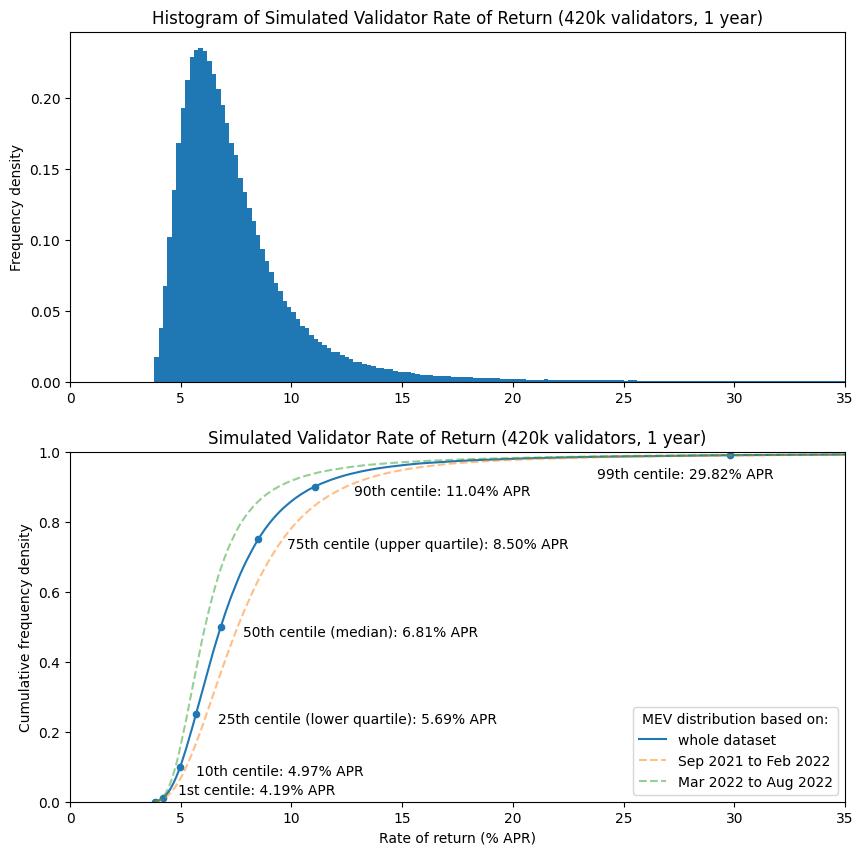

In [54]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 10))

bins = [e/5 for e in range(176)]
annual_full_rtn.hist(ax=ax1, bins=bins, density=True, grid=False)
ax1.set_title(
    'Histogram of Simulated Validator Rate of Return (420k validators, 1 year)'
)
ax1.set_xlim(0, 35)
ax1.set_ylabel('Frequency density')

quantiles = [0, .01, .1, .25, .5, .75, .9, .99, .999, 1]

table = pd.DataFrame({
    'quantile': quantiles,
    'centile': [100 * q for q in quantiles],
    'all': [annual_full_ecdf.get_quantile(q) for q in quantiles],
    'h1': [annual_full_ecdf_h1.get_quantile(q) for q in quantiles],
    'h2': [annual_full_ecdf_h2.get_quantile(q) for q in quantiles    ]
})
table.set_index('quantile', inplace=True, drop=False)
table.plot('all', 'quantile', kind='scatter', ax=ax2)

annual_full_ecdf.plot(ax=ax2, label="whole dataset")
annual_full_ecdf_h1.plot(
    ax=ax2, linestyle='dashed', alpha=0.5, label="Sep 2021 to Feb 2022"
)
annual_full_ecdf_h2.plot(
    ax=ax2, linestyle='dashed', alpha=0.5, label="Mar 2022 to Aug 2022"
)
                  
c1 = table['all'].loc[0.01]
ax2.annotate(f'1st centile: {c1:.2f}% APR', (c1 + 0.7, 0.02))
d1 = table['all'].loc[0.1]
ax2.annotate(f'10th centile: {d1:.2f}% APR', (d1 + 0.7, 0.075))
lq = table['all'].loc[0.25]
ax2.annotate(f'25th centile (lower quartile): {lq:.2f}% APR', (lq + 1, 0.225))
med = table['all'].loc[0.5]
ax2.annotate(f'50th centile (median): {med:.2f}% APR', (med + 1, 0.475))
uq = table['all'].loc[0.75]
ax2.annotate(f'75th centile (upper quartile): {uq:.2f}% APR', (uq + 1.3, 0.725))
d9 = table['all'].loc[0.9]
ax2.annotate(f'90th centile: {d9:.2f}% APR', (d9 + 1.8, 0.875))
c99 = table['all'].loc[0.99]
ax2.annotate(f'99th centile: {c99:.2f}% APR', (c99 - 6, 0.925))

ax2.set_title('Simulated Validator Rate of Return (420k validators, 1 year)')
ax2.set_xlabel('Rate of return (% APR)')
ax2.set_xlim(0, 35)
ax2.set_ylabel('Cumulative frequency density')
ax2.set_ylim(0, 1)
ax2.legend(title='MEV distribution based on:', loc='lower right')

plt.show()

table.drop('quantile', axis=1, inplace=True)
cols = [
    ('','centile<br>(%)'),
    ('Rate of return (% APR)<br>based on data from:','Sep 2021<br>to Aug 2022'),
    ('Rate of return (% APR)<br>based on data from:','Sep 2021<br>to Feb 2022'),
    ('Rate of return (% APR)<br>based on data from:','Mar 2022<br>to Aug 2022'),
]

fmts = ['{:.1f}'] + ['{:.2f}'] * 3
col_formats = {c: f for c, f in zip(cols, fmts)}
table.columns = pd.MultiIndex.from_tuples(cols)
display(
    table.style.set_table_styles(
        [dict(selector='th', props=[('text-align', 'center')])]
    ).hide(axis='index').format(col_formats)
)

## Interpretation

So, based on our full year historical MEV dataset, scaled to account for decreased mean block interval, we arrive at a simulated rate of return between around 5.7% and 8.5% for the "middle 50%" of validators. Meanwhile the "luckiest 1%" receive 30% APR, and the "unluckiest 1%" only 4.2%. The least profitable validator in the whole set still made a return of 3.8%, whilst the most profitable managed over 4500% (i.e. 45x) for the year. Bear in mind that the rates of return in this model are not compounded — in practice, operators earning such large returns may will choose to spin up new validators and therefore will begin earning a return on those too.

## Running Multiple Validators

The final question we're going to consider is what happens to the distribution of returns for stakers who are running multiple validators. In the plot and table below, the validators from our simulated set have been grouped into sets of 2, 4, 8, 16 and 32 validators, so we can compare the ECDFs of annual percentage rate for the different group sizes. Also shown (red dashed line) is the *mean* return from the whole validator set (i.e. the return each validator would earn if all MEV and beacon chain rewards were shared equally). The mean return is what we would expect very large validator groups (e.g. Lido, or very large institutional stakers) to earn before before any fees they subtract.

In [44]:
# calculate ECDFs for 1, 2, 4, 8, 16, 32 validators

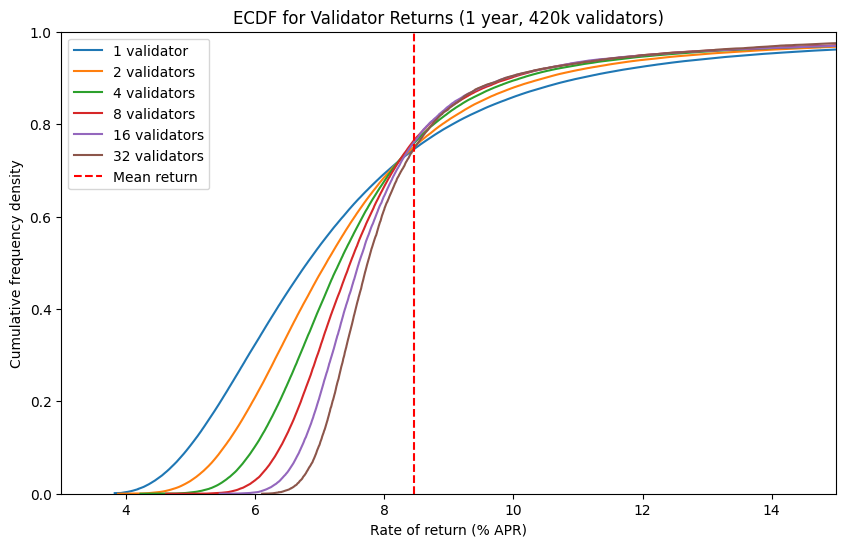

In [55]:
rtns = []
ecdfs = []
for e in range(6):
    ecdfs.append(Ecdf([
        100 * sum(validators[i:i+2**e]) / (32 * 2**e)
        for i in range(0, num_validators, 2**e)
    ]))

mean_return = 100 * sum(validators) / (32 * len(validators))
    
fig, ax = plt.subplots(figsize=(10, 6))
for e in range(6):
    label = '1 validator' if e == 0 else f'{2**e} validators'
    ecdfs[e].plot(ax=ax, label=label)

ax.set_xlim(3, 15)
ax.set_ylim(0, 1)
ax.set_title("ECDF for Validator Returns (1 year, 420k validators)")
ax.set_xlabel("Rate of return (% APR)")
ax.set_ylabel("Cumulative frequency density")
ax.axvline(mean_return, color='r', linestyle='dashed', label='Mean return')
ax.legend();

plt.show()

quantiles = [0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99, 0.999]

table = pd.DataFrame({'quantile': [100 * q for q in quantiles]})
for e in range(6):
    table[2**e] = [ecdfs[e].get_quantile(q) for q in quantiles]
cols = [('','centile<br>(%)')] + [
    ('Rate of return (% APR) for number of validators:', 2**e) for e in range(6)
]
fmts = ['{:.1f}'] + ['{:.2f}'] * 6
col_formats = {c: f for c, f in zip(cols, fmts)}
table.columns = pd.MultiIndex.from_tuples(cols)
display(
    table.style.set_table_styles(
        [dict(selector='th', props=[('text-align', 'center')])]
    ).hide(axis='index').format(col_formats)
)

## Conclusions

As I've tried to make clear throughout this article, it is not possible to make a reliable prediction of validator returns after the merge, since the amount of MEV being extracted is dependent on a number of unpredictable factors. Indeed, there are several factors which have not been explored in this article at all, such as the proportion of MEV which actually reaches miners/validators. While in an efficient market, we expect all MEV to end up in the hands of the party with the power of transaction inclusion and ordering (i.e. miners now, validators post-merge), it is not clear how efficient the market currently is. Longer term trends about application development (applications can — and should — be designed to minimise the MEV they expose), and an open question about how much of the current on-chain activity will migrate to L2 blockchains, mean that even the most well reasoned prediction about the future returns is bound to be at best an educated guess.

Finally, I haven't dealt with the fact that after the merge, the identity of the proposer for a given slot is known in advance. This feature of current proof of stake blockchains allows new possibilities for atomic cross-chain transactions (since validators with a significant proportion of stake may be able to guarantee coincident block proposals on multiple blockchains), as well as multi-block MEV. How these effects will play out remains a big unknown.

What is slightly more predictable is the level of variation in validator returns across the validator set, since several aspects of validators' earnings are based on chance. The effect of grouping together validators to even out returns is also straightforward to model, as shown above. Hopefully the calculations and graphs above can be a rough guide for how to think about these questions.